In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tf-nightly

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-n1_6anh7
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-n1_6anh7
  Created wheel for tensorflow-examples: filename=tensorflow_examples-335ab713ed7361f0a476c457eb4fe557e435d72d_-cp36-none-any.whl size=134284 sha256=040061ec919ff175bb0f3a7d09e96b75d461abe27c8120fa596cd2714be0d100
  Stored in directory: /tmp/pip-ephem-wheel-cache-vgh8kker/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


## Set up the input pipeline

Following the tutorial from <https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np
import os
import PIL
import PIL.Image

In [ ]:
import pathlib
data_dir = '/content/drive/My Drive/dataset/Plots'#tf.keras.utils.get_file(origin='/content/drive/My Drive/dataset/Plots',
                                 #  fname='Plots',
                                 #  untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
data_dir2 = '/content/drive/My Drive/dataset/Components'
data_dir2 = pathlib.Path(data_dir2)

In [ ]:
image_count = len(list(data_dir.glob('*.png')))
print("Polar Plots: ",image_count)

image_count_2 = len(list(data_dir.glob('*.png')))
print("Component Plots: ",image_count_2)


Polar Plots:  6459
Component Plots:  6459


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)



In [ ]:
list_ds2 = tf.data.Dataset.list_files(str(data_dir2/'*'), shuffle=False)
list_ds2 = list_ds2.shuffle(image_count_2, reshuffle_each_iteration=False)


In [ ]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/drive/My Drive/dataset/Plots/Plot_4,875.png'
b'/content/drive/My Drive/dataset/Plots/Plot_344.png'
b'/content/drive/My Drive/dataset/Plots/Plot_1,250.png'
b'/content/drive/My Drive/dataset/Plots/Plot_818.png'
b'/content/drive/My Drive/dataset/Plots/Plot_1,796.png'


In [ ]:
for f in list_ds2.take(5):
  print(f.numpy())


b'/content/drive/My Drive/dataset/Components/Comp_5,051.png'
b'/content/drive/My Drive/dataset/Components/Comp_3,385.png'
b'/content/drive/My Drive/dataset/Components/Comp_1,798.png'
b'/content/drive/My Drive/dataset/Components/Comp_715.png'
b'/content/drive/My Drive/dataset/Components/Comp_2,085.png'


In [ ]:

class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)


['Plot_1,000.png' 'Plot_1,001.png' 'Plot_1,002.png' ... 'Plot_997.png'
 'Plot_998.png' 'Plot_999.png']


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir2.glob('*')]))
print(class_names)


['Comp_1,000.png' 'Comp_1,001.png' 'Comp_1,002.png' ... 'Comp_997.png'
 'Comp_998.png' 'Comp_999.png']


In [ ]:
val_size = int(image_count * 0.07)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(image_count)

6459


In [ ]:
val_size2 = int(image_count_2 * 0.07)
train_ds2 = list_ds2.skip(val_size2)
val_ds2 = list_ds2.take(val_size2)
print(val_size2)

1291


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

5168
1291


In [ ]:
print(tf.data.experimental.cardinality(train_ds2).numpy())
print(tf.data.experimental.cardinality(val_ds2).numpy())

5168
1291


In [ ]:

img_height = 256
img_width = 256
batch_size = 4
Buffer_size = 100

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  print("label: ",label)
  # load the raw data from the file as a string

  image = tf.io.read_file(file_path)
  image = decode_img(image)

    # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  cropped_image = tf.image.random_crop(
    image, size=[img_height, img_width, 3])

  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.random_flip_left_right(image)

  #image = tf.cast(image, tf.float32)

  image = (image / 127.5) - 1

  """
  img = tf.image.resize(img, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = tf.image.random_crop(
    img, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  img = tf.image.random_flip_left_right(img)

  IMG_HEIGHT = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  """

  return image

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size= Buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_plots = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_plots = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


label:  Tensor("ArgMax:0", shape=(), dtype=int64)
label:  Tensor("ArgMax:0", shape=(), dtype=int64)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_comps = train_ds2.map(process_path, num_parallel_calls=AUTOTUNE)
val_comps = val_ds2.map(process_path, num_parallel_calls=AUTOTUNE)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


label:  Tensor("ArgMax:0", shape=(), dtype=int64)
label:  Tensor("ArgMax:0", shape=(), dtype=int64)


In [ ]:
train_plots = configure_for_performance(train_plots)
val_plots = configure_for_performance(val_plots)
train_comps = configure_for_performance(train_comps)
val_comps = configure_for_performance(val_comps)

### Tutorial code ends
The default cylceGAN code starts

In [ ]:
print(type(train_plots))
print(type(train_comps))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [ ]:
start = time.time()
sample_plot = next(iter(train_plots))
print("next")
sample_comp = next(iter(train_comps))
print("End")
t = time.time()-start
t = t/60
print("Time taken (mins): ",t)

next
End
Time taken (mins):  0.903061048189799


## Import and reuse the Pix2Pix models

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
print(np.shape((sample_plot)),"----",type(sample_plot))
print(np.shape(sample_comp),"----",type(sample_comp))

(4, 256, 256, 3) ---- <class 'tensorflow.python.framework.ops.EagerTensor'>
(4, 256, 256, 3) ---- <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
to_comp = generator_g(sample_plot)
to_plot = generator_f(sample_comp)

In [ ]:
print(np.shape(to_plot))
print(np.shape(to_comp))

(4, 256, 256, 3)
(4, 256, 256, 3)


## Loss functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
#!cp -R "./checkpoints/train" "./drive/My Drive/Colab Notebooks/checkpoints"
#%cd /gdrive/My\ Drive/{location you want to move}

In [ ]:

#checkpoint_path = "./checkpoints/train"

checkpoint_path = "/content/drive/My Drive/Colab Notebooks/checkpoints/train"
#%ls "/content/drive/My Drive/Colab Notebooks/checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
else:
  print('No checkpoint found')


Latest checkpoint restored!!


## Training

In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
from google.colab import files

In [ ]:
def generate_images_save(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  plt.savefig('test.png')
  files.download('test.png')
  images_dir = '/content/drive/My Drive/CycleGAN Test Plots/'
  plt.savefig(f"{images_dir}/test.png")
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

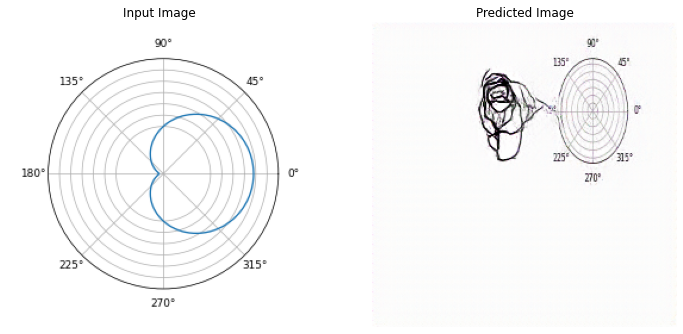

<dtype: 'float32'>


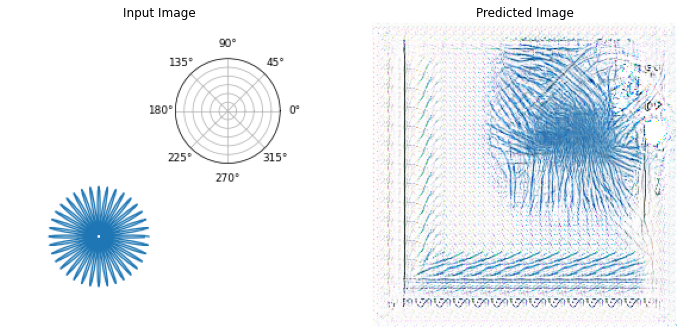

<dtype: 'float32'>


In [ ]:
sample_plot = next(iter(train_plots))
sample_comp = next(iter(train_comps))

generate_images(generator_g, sample_plot)
print(sample_plot.dtype)
generate_images(generator_f,sample_comp)
print(sample_comp.dtype)


n:  1292
Forward


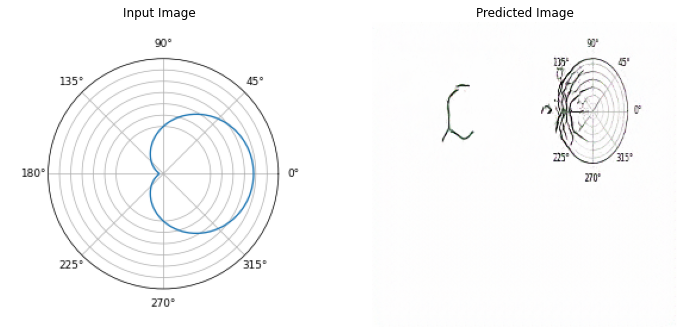

Backwarsds


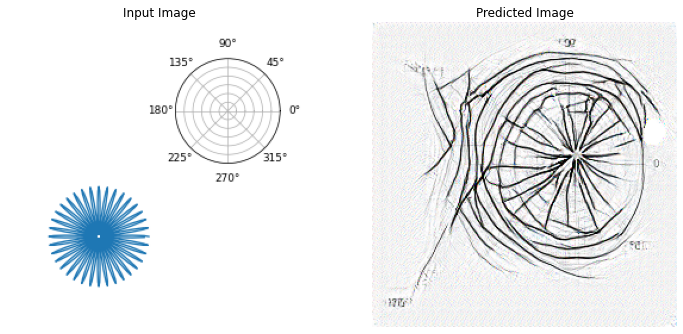

Saving checkpoint for epoch 9/100 at /content/drive/My Drive/Colab Notebooks/checkpoints/train/ckpt-41
Time taken for epoch 9 is 0.9650244981712766 hours

Epoch:  10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 
 10.06 % Completed 
130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  prev = 0
  n = 0
  print("Epoch: ",(epoch+1))
  for image_x,image_y in tf.data.Dataset.zip((train_plots,train_comps)):
    train_step(image_x, image_y)
    z = ((n+1)*100/1292.0)
    f = "{:.2f}".format(z)
    if int(z) % 10 == 0 and int(z) != 0 and int(z) != prev:
      prev = int(z)
      print("\n", f,"% Completed ")
    else:
      print(n,end = ' ')
    n+=1

  clear_output(wait=True)
  print("n: ",n)
  # Using a consistent image (sample_plot) so that the progress of the model
  # is clearly visible.
  print("Forward")
  generate_images(generator_g, sample_plot)
  print("Backwarsds")
  generate_images(generator_f,sample_comp)


  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {}/{} at {}'.format(epoch+1,EPOCHS, ckpt_save_path))
  t = time.time()-start
  t = t/3600
  print ('Time taken for epoch {} is {} hours\n'.format(epoch + 1,
                                                      t))

In [ ]:
for epoch in range(1):
  start = time.time()
  prev = 0
  n = 0
  print("Epoch: ",(epoch+1))
  for image_x, image_y in tf.data.Dataset.zip((train_plots, train_comps)):
    #train_step(image_x, image_y)
    #z = ((n+1)*100/5169.0)
    #f = "{:.2f}".format(z)
    #if int(z) % 10 == 0 and int(z) != 0 and int(z) != prev:
    #  prev = int(z)
    #  print("\n", f,"% Completed ")
    #else:
    #  if n%2 ==0:
    #    print('\\', end = '')
    #  else:
    #    print('/',end = '')
    n+=1

  #clear_output(wait=True)
  # Using a consistent image (sample_plot) so that the progress of the model
  # is clearly visible.
  print("Forward")
  #generate_images(generator_g, sample_plot)
  print("Backwarsds")
  #generate_images(generator_f,sample_comp)

  if (epoch + 1) % 1 == 0:
#    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {}/{} at {}')#.format(epoch+1,EPOCHS,
 #                                                        ckpt_save_path))
  t = time.time()-start
  t = t/3600
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      t))

In [ ]:
print("Forward")
generate_images(generator_g, sample_plot)
print("Backwards")
generate_images(generator_f,sample_comp)



## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in val_ds.take(5):
  generate_images(generator_g, inp)

In [ ]:
# Run the trained model on the test dataset
for inp in val_ds2.take(5):
  generate_images(generator_f, inp)

# Visualisation 01


```
`# Source: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb?authuser=1#scrollTo=-5tES8rXFjux
```



To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
mymodel = discriminator_x #generator_f and discriminator_x converts zebra->horses and generator_g and discriminator_y horses->zebras

In [ ]:
zebra_image = next(iter(train_zebras))
generate_images_save(generator_f,zebra_image)

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
from numpy import asarray

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.

successive_outputs = [layer.output for layer in mymodel.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = mymodel.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
image = zebra_image
img_path = (image )
img = img_path
#img.set_shape((150,150,3))
#x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
#x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
x = np.array(img)
# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in mymodel.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
a = 1
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = 1#feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    #plt.figure( figsize=(scale * n_features, scale) )
    plt.figure (figsize = (10,10))
    plt.title ( layer_name,fontsize=20 )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    name = 'layer_image_' + str(a) +'.png'
    plt.savefig(name)
    files.download(name)
    a+=1
#mymodel.summary()

# Visualisation 02


In [ ]:
for i in range(len(mymodel.layers)):
	layer = mymodel.layers[i]
	# check for convolutional layer
#	if 'conv' not in layer.name:
#		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from matplotlib import pyplot


In [ ]:
from keras.models import Model


In [ ]:
filters, biases = mymodel.layers[9].get_weights() #_____.layers add model of your own code here.
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 1, 1
ax = pyplot.figure(figsize=(10,10))
for i in range(n_filters):
	# get the filter

	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis

		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
pyplot.savefig("Visualisation2.png")
# show the figure

In [ ]:
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [5]
outputs = [mymodel.layers[i].output for i in ixs]
mymodel = Model(inputs=mymodel.inputs, outputs=outputs)
# load the image with the required shape
img = load_image('/content/drive/My Drive/emoji.png')
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = mymodel.predict(img)
# plot the output from each block
square = 8

In [ ]:
z = 0
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ax = pyplot.figure(figsize=(8,8))
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square ,ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1])
			ix += 1
	# show the figure
	pyplot.savefig("/content/drive/My Drive/Visualization/seen/ntA-B_layers["+str(z)+"].png")
  pyplot.show()
	z = z + 1

# Visualisation 03

In [ ]:
generate_images(mymodel,zebra_image)